**Forecasting Total Cinema Sales**<br>

Menggunakan Algoritma **Random Forest**, **Extreme Gradient Boosting**, **Linear Regression**, **ARIMA**, dan **SARIMA**

---
---

# Import Package and Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from jcopml.time_series.decomposition import additive_decomposition

pd.set_option('display.float_format', lambda x: '%.4f' % x)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

d:\Python\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
df = pd.read_csv("data/data.csv", parse_dates=['date'])
df.head()

,film_code,cinema_code,total_sales,tickets_sold,tickets_out,show_time,occu_perc,ticket_price,ticket_use,capacity,date,month,quarter,day
0,1492,304,3900000,26,0,4,4.2600,150000.0000,26,610.3286,2018-05-05,5,2,5
1,1492,352,3360000,42,0,5,8.0800,80000.0000,42,519.8020,2018-05-05,5,2,5
2,1492,489,2560000,32,0,4,20.0000,80000.0000,32,160.0000,2018-05-05,5,2,5
3,1492,429,1200000,12,0,1,11.0100,100000.0000,12,108.9918,2018-05-05,5,2,5
4,1492,524,1200000,15,0,3,16.6700,80000.0000,15,89.9820,2018-05-05,5,2,5


# Data Cleaning

In [3]:
print("Data memiliki", df.shape[0], "baris dan", df.shape[1], "kolom")

Data memiliki 142524 baris dan 14 kolom


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142524 entries, 0 to 142523
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   film_code     142524 non-null  int64         
 1   cinema_code   142524 non-null  int64         
 2   total_sales   142524 non-null  int64         
 3   tickets_sold  142524 non-null  int64         
 4   tickets_out   142524 non-null  int64         
 5   show_time     142524 non-null  int64         
 6   occu_perc     142399 non-null  float64       
 7   ticket_price  142524 non-null  float64       
 8   ticket_use    142524 non-null  int64         
 9   capacity      142399 non-null  float64       
 10  date          142524 non-null  datetime64[ns]
 11  month         142524 non-null  int64         
 12  quarter       142524 non-null  int64         
 13  day           142524 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(10)
memory usage: 15.2 MB


In [5]:
missing_value = df[df.columns[(df.isna().sum() > 0)]]
duplicate_data = df.duplicated().sum()

print("Missing Value")
print(missing_value.isnull().sum())
print("\nDuplicate Data", duplicate_data, "Row")

Missing Value
occu_perc    125
capacity     125
dtype: int64

Duplicate Data 106 Row


In [6]:
pd.DataFrame(data = [df.isna().sum()/df.shape[0]*100],
             index=["Missing Data (%)"]).T.style.background_gradient(cmap='summer_r')

,Missing Data (%)
film_code,0.000000
cinema_code,0.000000
total_sales,0.000000
tickets_sold,0.000000
tickets_out,0.000000
show_time,0.000000
occu_perc,0.087705
ticket_price,0.000000
ticket_use,0.000000
capacity,0.087705


### Membuang Data yang Duplikat dan Missing Value

Melihat data yang duplikat pada data pertama

In [7]:
df[df.duplicated(keep='first')]

,film_code,cinema_code,total_sales,tickets_sold,tickets_out,show_time,occu_perc,ticket_price,ticket_use,capacity,date,month,quarter,day
56269,1484,448,324719994,2170,0,13,83.4900,149640.5502,2170,2599.1137,2018-03-24,3,1,24
56270,1484,637,304000000,1700,0,1,NaN,178823.5294,1700,NaN,2018-03-24,3,1,24
56271,1484,344,136500000,914,3,6,57.2000,149343.5449,911,1597.9021,2018-03-24,3,1,24
56272,1484,304,98100000,661,0,5,87.2000,148411.4977,661,758.0275,2018-03-24,3,1,24
56273,1484,163,97080000,813,0,8,80.6500,119409.5941,813,1008.0595,2018-03-24,3,1,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56370,1484,315,2500000,50,0,2,16.6700,50000.0000,50,299.9400,2018-03-24,3,1,24
56371,1484,487,1600000,16,0,5,1.3100,100000.0000,16,1221.3740,2018-03-24,3,1,24
56372,1484,472,1575000,25,0,1,8.6800,63000.0000,25,288.0184,2018-03-24,3,1,24
56373,1484,299,1100000,28,0,2,3.0000,39285.7143,28,933.3333,2018-03-24,3,1,24


Membuang data yang duplikat

In [8]:
df.drop_duplicates(keep='first', inplace=True)

Melihat data missing value

In [9]:
df[df.isnull().any(axis=1)]

,film_code,cinema_code,total_sales,tickets_sold,tickets_out,show_time,occu_perc,ticket_price,ticket_use,capacity,date,month,quarter,day
8691,1498,181,900000,13,0,3,NaN,69230.7692,13,NaN,2018-08-25,8,3,25
9773,1498,514,2720000,34,0,4,NaN,80000.0000,34,NaN,2018-08-08,8,3,8
9898,1498,477,550000,22,0,1,NaN,25000.0000,22,NaN,2018-08-07,8,3,7
21923,1511,273,250000,5,0,1,NaN,50000.0000,5,NaN,2018-08-11,8,3,11
21972,1511,273,150000,3,0,1,NaN,50000.0000,3,NaN,2018-08-09,8,3,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138287,1556,543,300000,6,0,1,NaN,50000.0000,6,NaN,2018-09-07,9,3,7
138438,1556,543,150000,3,0,1,NaN,50000.0000,3,NaN,2018-09-06,9,3,6
138570,1556,543,100000,2,0,1,NaN,50000.0000,2,NaN,2018-09-05,9,3,5
138703,1556,543,500000,10,0,1,NaN,50000.0000,10,NaN,2018-09-04,9,3,4


# Exploratory Data Analysis

In [10]:
print(f"Data Tanggal\n{[', '.join(map(str, df['day'].sort_values().unique()))]}\n")
print(f"Data Bulan\n{[', '.join(map(str, df['month'].sort_values().unique()))]}\n")
print(f"Data Quarter\n{[', '.join(map(str, df['quarter'].sort_values().unique()))]}\n")
print(f"Data Tahun\n{pd.to_datetime(df['date']).dt.year.unique()}")

Data Tanggal
['1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31']

Data Bulan
['2, 3, 4, 5, 6, 7, 8, 9, 10, 11']

Data Quarter
['1, 2, 3, 4']

Data Tahun
[2018]


In [11]:
date_min = df['date'].dt.date.min()
date_max = df['date'].dt.date.max()

print(f'Tanggal dimulai dari {date_min} hingga {date_max}')

df = df.set_index('date')
print(f"Dates which are missing\n{pd.date_range(start=str(date_min), end=str(date_max)).difference(df.index)}")
df = df.reset_index()

Tanggal dimulai dari 2018-02-21 hingga 2018-11-04
Dates which are missing
DatetimeIndex(['2018-02-22', '2018-02-24', '2018-02-25', '2018-02-26',
               '2018-02-27', '2018-02-28', '2018-03-01', '2018-03-02',
               '2018-03-03', '2018-03-04', '2018-03-05', '2018-03-06',
               '2018-03-07', '2018-03-08', '2018-03-09', '2018-03-10',
               '2018-03-11', '2018-03-12', '2018-03-13', '2018-06-04',
               '2018-06-06', '2018-09-19', '2018-09-20'],
              dtype='datetime64[ns]', freq=None)


### Melihat Kolom Film Code

In [12]:
print(df['film_code'].nunique(), "Jenis Film\n")
print(df['film_code'].unique())

48 Jenis Film

[1492 1567 1497 1498 1494 1486 1496 1511 1563 1589 1566 1550 1499 1551
 1558 1565 1568 1562 1512 1575 1495 1471 1480 1559 1570 1584 1587 1484
 1553 1573 1571 1483 1552 1576 1560 1502 1554 1572 1564 1557 1485 1482
 1481 1500 1578 1493 1556 1569]


### Melihat Kolom Cinema Code

In [13]:
print(df['cinema_code'].nunique(), "Jenis Cinema\n")
print(df['cinema_code'].unique())

246 Jenis Cinema

[304 352 489 429 524  71 163 450  51 522  43 529  82 344  73 485 518 448
 431  72 144 456 238 312 168 254 214 474 445 300 362 324 452 291 479 210
 428 277  56 253 243  39 310 201 457 191 532 167 266 204 380 169 162 506
 537 513 467 509 165 262 486 198 508 222  98 230 156 181 141 528  94 350
 442 556 475 142  35  89  34 225 182 396  50  61 487  88 338 417 194  57
 285 187 159 184  81 207 339 326 531 505 492 299 507 316 333 172 526 414
 115 468 490 441 430 472 511 480 470 496 466 381 368 498 195 546 516 425
 488 535 196 453 321 152 390 166 247 454 464 499 460 251 481 315 307 120
 250 533 221 248 313 164  70 180 160 495 314 415 174 259 471 245  83  91
 365 359 286  64 426 237 536 397 476 503 491 517  55 170 175  62 539 541
 540 484 514 548 432 501 447 186 477 331 515  48  33 185 155 455 461 534
 273 504 249  52 482 323 451 341 306 413 292 463 223 497 525 427 231 519
 183  32 553 271 276 154 521 502 402 158 473 465 561 328 558 562 424 512
 560 458 637 520 557 555 543 542 

### Membuat Kolom Film ID

In [14]:
df['date'] = df['date'].dt.date

df['film_id'] = df[['film_code','cinema_code','date']].apply(lambda row:'_'.join(row.values.astype(str)), axis=1)
df = df[['film_id'] + [kolom for kolom in df.columns if kolom != 'film_id']]

df.head()

,film_id,date,film_code,cinema_code,total_sales,tickets_sold,tickets_out,show_time,occu_perc,ticket_price,ticket_use,capacity,month,quarter,day
0,1492_304_2018-05-05,2018-05-05,1492,304,3900000,26,0,4,4.2600,150000.0000,26,610.3286,5,2,5
1,1492_352_2018-05-05,2018-05-05,1492,352,3360000,42,0,5,8.0800,80000.0000,42,519.8020,5,2,5
2,1492_489_2018-05-05,2018-05-05,1492,489,2560000,32,0,4,20.0000,80000.0000,32,160.0000,5,2,5
3,1492_429_2018-05-05,2018-05-05,1492,429,1200000,12,0,1,11.0100,100000.0000,12,108.9918,5,2,5
4,1492_524_2018-05-05,2018-05-05,1492,524,1200000,15,0,3,16.6700,80000.0000,15,89.9820,5,2,5


Kolom Film ID merupakan gabungan dari Kolom Film Code, Cinema Code, dan Date untuk melihat apakah terdapat data yang duplikat

### Melihat Duplicate Data

In [15]:
print("Duplicate Data Film ID\t", df['film_id'].duplicated().sum())

Duplicate Data Film ID	 0


Pada Kolom Film ID, tidak terdapat duplicate data

## Analysis with Visualization

In [16]:
#sns.pairplot(df, hue='film_code', corner=True)

In [17]:
from sklearn.preprocessing import StandardScaler

In [18]:
data = df[['date', 'total_sales', 'tickets_sold']]
data['date'] = pd.to_datetime(data['date'])
data[['total_sales', 'tickets_sold']] = StandardScaler().fit_transform(data[['total_sales', 'tickets_sold']])
data

,date,total_sales,tickets_sold
0,2018-05-05,-0.2753,-0.4077
1,2018-05-05,-0.2930,-0.3505
2,2018-05-05,-0.3191,-0.3863
3,2018-05-05,-0.3635,-0.4578
4,2018-05-05,-0.3635,-0.4470
...,...,...,...
142413,2018-11-04,-0.3596,-0.4220
142414,2018-11-04,-0.3635,-0.4470
142415,2018-11-04,-0.3680,-0.4721
142416,2018-11-04,-0.3831,-0.4828


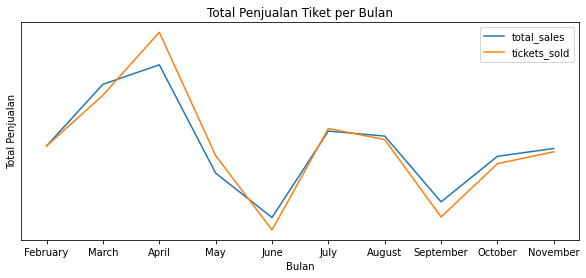

In [19]:
data = df[['date', 'total_sales', 'tickets_sold']]
data['date'] = pd.to_datetime(data['date'])
data[['total_sales', 'tickets_sold']] = StandardScaler().fit_transform(data[['total_sales', 'tickets_sold']])

total_sales = data.groupby('date')['total_sales'].sum()
total_sales = total_sales.resample('M').sum()

tickets_sold = data.groupby('date')['tickets_sold'].sum()
tickets_sold = tickets_sold.resample('M').sum()

date = data['date'].sort_values()
date = date.dt.month_name().unique()

plt.figure(figsize=(10, 4))
plt.plot(date, total_sales)
plt.plot(date, tickets_sold)
plt.legend(["total_sales", "tickets_sold"])

plt.xticks(date)
plt.xlabel("Bulan")
plt.ylabel("Total Penjualan")
plt.title("Total Penjualan Tiket per Bulan")
plt.yticks([])
plt.show()

Distribusi data pada kolom **tickets_sold** per bulan

<AxesSubplot:xlabel='date'>

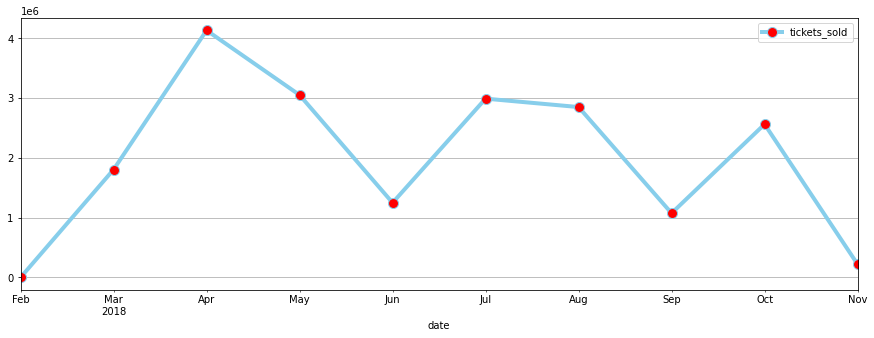

In [20]:
series = df[['tickets_sold', 'date']]
series['date'] = pd.to_datetime(series['date'])
series = series.set_index('date')

series = series.resample('M').sum()
series.plot(figsize=(15,5), grid=True, marker='o', markerfacecolor='red', markersize=10, color='skyblue', linewidth=4)

Distribusi data pada kolom **total_sales** per bulan

<AxesSubplot:xlabel='date'>

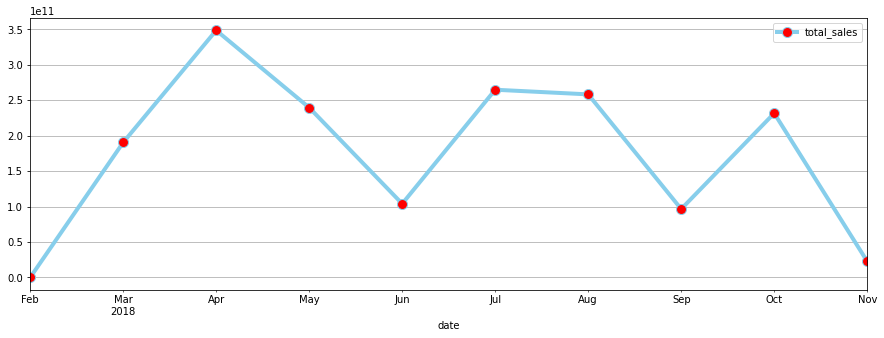

In [21]:
series = df[['total_sales', 'date']]
series['date'] = pd.to_datetime(series['date'])
series = series.set_index('date')

series = series.resample('M').sum()
series.plot(figsize=(15,5), grid=True, marker='o', markerfacecolor='red', markersize=10, color='skyblue', linewidth=4)

Distribusi data pada kolom **total_sales** per hari dalam satu bulan

<AxesSubplot:xlabel='date'>

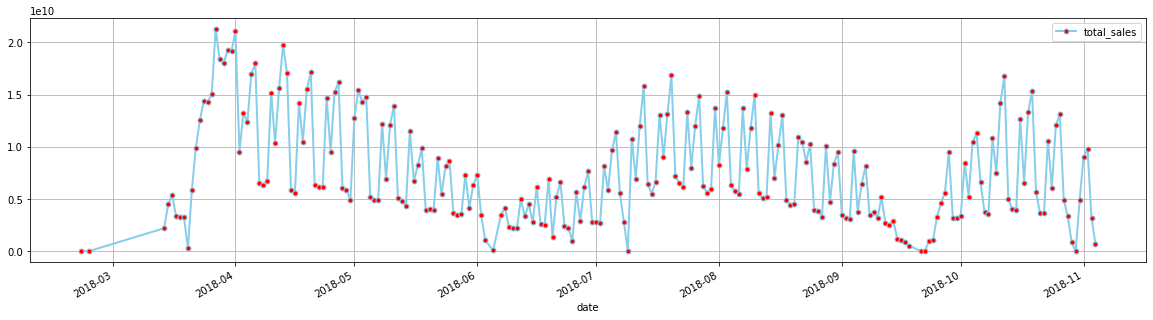

In [22]:
series = df[['total_sales', 'date']]
series['date'] = pd.to_datetime(series['date'])
series = series.groupby('date').sum().sort_values(by='date')
series.plot(figsize=(20,5), grid=True, marker='o', markerfacecolor='red', markersize=5, color='skyblue', linewidth=2)

Distribusi data pada kolom **tickets_sold** per hari dalam satu bulan

<AxesSubplot:xlabel='date'>

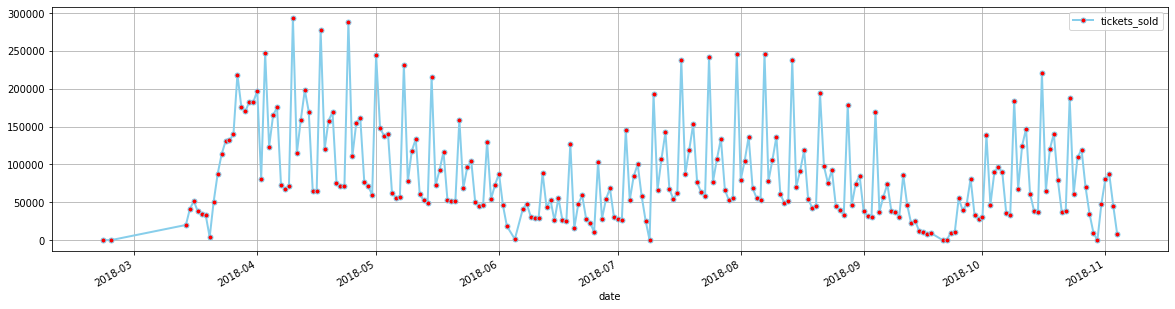

In [23]:
series = df[['tickets_sold', 'date']]
series['date'] = pd.to_datetime(series['date'])
series = series.groupby('date').sum().sort_values(by='date')
series.plot(figsize=(20,5), grid=True, marker='o', markerfacecolor='red', markersize=5, color='skyblue', linewidth=2)

Melihat total penjualan tiket per bulan

In [24]:
series = df[['total_sales', 'tickets_sold', 'date']]
series['date'] = pd.to_datetime(series['date']).dt.month_name()
series.groupby('date')['total_sales', 'tickets_sold'].sum().sort_values(by=['total_sales', 'tickets_sold'], ascending=False)


,total_sales,tickets_sold
date,,
April,348614664007,4134613
July,264855462688,2992026
August,258296800764,2851380
May,239595373317,3052733
October,231675849820,2563955
March,190503375738,1805330
June,104001473893,1249595
September,96569594964,1074979
November,22708024998,220511


Melihat total penjualan tiket per film

In [25]:
film_code = df.groupby(['film_code'])['tickets_sold', 'total_sales'].sum().sort_values(ascending=False, by='tickets_sold').reset_index()
print(f"Penjualan Lima Teratas Per Film\n{film_code.head()}", '\n')
print(f"Penjualan Lima Terbawah Per Film\n{film_code.tail()}", '\n')

Penjualan Lima Teratas Per Film
   film_code  tickets_sold   total_sales
0       1554       4129543  372740376637
1       1484       1761782  148011447334
2       1493       1719867  144169741258
3       1482       1628821  130526074406
4       1483       1623569  156913458770 

Penjualan Lima Terbawah Per Film
    film_code  tickets_sold  total_sales
43       1570          6838    610710000
44       1565          5793    547609999
45       1567          4773    440925000
46       1589           812     90555000
47       1584           176     16490000 



Melihat total penjualan tiket per cinema

In [26]:
cinema_code = df.groupby(['cinema_code'])['tickets_sold', 'total_sales'].sum().sort_values(ascending=False, by='tickets_sold').reset_index()
print(f"Penjualan Lima Teratas Per Cinema\n{cinema_code.head()}", '\n')
print(f"Penjualan Lima Terbawah Per Cinema\n{cinema_code.tail()}", '\n')

Penjualan Lima Teratas Per Cinema
   cinema_code  tickets_sold   total_sales
0          448       1683313  213905979826
1          304        786023  101602933000
2          163        612029   62755809999
3          489        520199   58760547000
4          518        495912   39849453995 

Penjualan Lima Terbawah Per Cinema
     cinema_code  tickets_sold  total_sales
241          542           371     18780000
242          565           316      9680000
243          543           209      9510000
244          424            67     10050000
245          566            40      4000000 



# Statistik Data

In [27]:
df[['total_sales', 'tickets_sold']].describe()

,total_sales,tickets_sold
count,142418.0000,142418.0000
mean,12335890.3382,140.0483
std,30637687.0661,279.7253
min,20000.0000,1.0000
25%,1260000.0000,18.0000
50%,3710000.0000,50.0000
75%,11100000.0000,143.0000
max,1262819994.0000,8499.0000


In [28]:
kategorik = df.columns[df.nunique() < 300].drop(['date', 'month', 'quarter', 'day'])
df[kategorik].astype('object').describe()

,film_code,cinema_code,tickets_out,show_time
count,142418,142418,142418,142418
unique,48,246,96,51
top,1554,524,0,3
freq,11614,2473,136297,28759


# Korelasi

In [29]:
korelasi = df.copy()
korelasi.drop(columns=['film_id', 'month', 'day', 'quarter'], inplace=True)
korelasi.corr()

,film_code,cinema_code,total_sales,tickets_sold,tickets_out,show_time,occu_perc,ticket_price,ticket_use,capacity
film_code,1.0000,0.0295,0.0102,-0.0053,-0.0010,0.0769,-0.1038,0.1050,-0.0053,0.0614
cinema_code,0.0295,1.0000,-0.0130,-0.0537,0.0195,-0.1871,0.1257,0.0051,-0.0540,-0.3534
total_sales,0.0102,-0.0130,1.0000,0.9152,0.0669,0.5100,0.4143,0.2721,0.9151,0.3763
tickets_sold,-0.0053,-0.0537,0.9152,1.0000,0.0715,0.5221,0.4937,0.1032,0.9999,0.4255
tickets_out,-0.0010,0.0195,0.0669,0.0715,1.0000,0.0789,0.0444,0.0119,0.0611,0.0376
show_time,0.0769,-0.1871,0.5100,0.5221,0.0789,1.0000,0.0556,0.1762,0.5217,0.6817
occu_perc,-0.1038,0.1257,0.4143,0.4937,0.0444,0.0556,1.0000,0.0844,0.4936,-0.1411
ticket_price,0.1050,0.0051,0.2721,0.1032,0.0119,0.1762,0.0844,1.0000,0.1032,0.0043
ticket_use,-0.0053,-0.0540,0.9151,0.9999,0.0611,0.5217,0.4936,0.1032,1.0000,0.4254
capacity,0.0614,-0.3534,0.3763,0.4255,0.0376,0.6817,-0.1411,0.0043,0.4254,1.0000


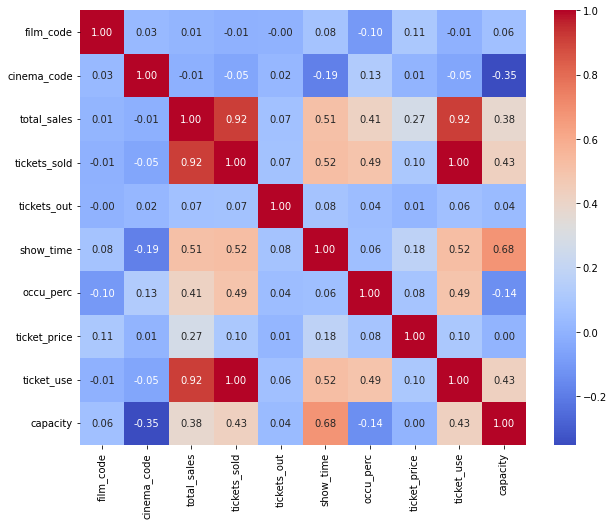

In [30]:
plt.figure(figsize=(10,8))
sns.heatmap(korelasi.corr(), annot=True, cmap='coolwarm', fmt='.2f');

In [31]:
korelasi.corr()['total_sales'].sort_values(ascending=False)

total_sales     1.0000
tickets_sold    0.9152
ticket_use      0.9151
show_time       0.5100
occu_perc       0.4143
capacity        0.3763
ticket_price    0.2721
tickets_out     0.0669
film_code       0.0102
cinema_code    -0.0130
Name: total_sales, dtype: float64

In [32]:
korelasi.corr()['tickets_sold'].sort_values(ascending=False)

tickets_sold    1.0000
ticket_use      0.9999
total_sales     0.9152
show_time       0.5221
occu_perc       0.4937
capacity        0.4255
ticket_price    0.1032
tickets_out     0.0715
film_code      -0.0053
cinema_code    -0.0537
Name: tickets_sold, dtype: float64

# Mengatasi Outliers

Tidak mengatasi data yang outliers

In [33]:
# fig, axes = plt.subplots(4,2, figsize=(20,20))
# sns.boxplot(x="total_sales", data=df, ax=axes[0, 0])
# sns.boxplot(x="tickets_sold", data=df, ax=axes[0, 1])
# sns.boxplot(x="ticket_price", data=df, ax=axes[1, 0])
# sns.boxplot(x="ticket_use", data=df, ax=axes[1, 1])

# sns.boxplot(x="capacity", data=df, ax=axes[2, 0])
# sns.boxplot(x="show_time", data=df, ax=axes[2, 1])
# sns.boxplot(x="occu_perc", data=df, ax=axes[3, 0])
# sns.boxplot(x="tickets_out", data=df, ax=axes[3, 1])

In [34]:
# numeric = ['total_sales', 'tickets_sold', 'ticket_price', 'ticket_use', 'capacity', 'show_time', 'occu_perc', 'tickets_out']

# old = df.shape
# df_forecast = df.copy()

# z = np.abs(stats.zscore(df[numeric]))
# df = (df[(z<3).all(axis=1)])

# new = df.shape
# print("Jumlah data sebelum ZScore : ", old)
# print("Jumlah data sesudah ZScore : ", new)

In [35]:
# fig, axes = plt.subplots(4,2, figsize=(20,20))
# sns.boxplot(x="total_sales", data=df, ax=axes[0, 0])
# sns.boxplot(x="tickets_sold", data=df, ax=axes[0, 1])
# sns.boxplot(x="ticket_price", data=df, ax=axes[1, 0])
# sns.boxplot(x="ticket_use", data=df, ax=axes[1, 1])

# sns.boxplot(x="capacity", data=df, ax=axes[2, 0])
# sns.boxplot(x="show_time", data=df, ax=axes[2, 1])
# sns.boxplot(x="occu_perc", data=df, ax=axes[3, 0])
# sns.boxplot(x="tickets_out", data=df, ax=axes[3, 1])

# Preprocessing

In [36]:
df[['total_sales', 'tickets_sold']].describe().loc[['min', 'max', 'mean', '50%', 'std']]

,total_sales,tickets_sold
min,20000.0000,1.0000
max,1262819994.0000,8499.0000
mean,12335890.3382,140.0483
50%,3710000.0000,50.0000
std,30637687.0661,279.7253


In [37]:
df[['total_sales', 'tickets_sold']].skew()

total_sales    9.9536
tickets_sold   6.7982
dtype: float64

In [38]:
df[['total_sales', 'tickets_sold']].kurtosis()

total_sales    181.1523
tickets_sold    84.0680
dtype: float64

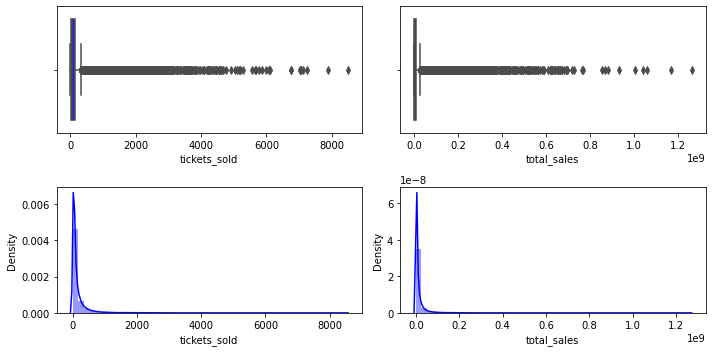

In [39]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 5))

sns.boxplot(df['tickets_sold'], ax=axes[0, 0], color='blue')
sns.boxplot(df['total_sales'], ax=axes[0, 1], color='blue')

sns.distplot(df['tickets_sold'], ax=axes[1, 0], color='blue')
sns.distplot(df['total_sales'], ax=axes[1, 1], color='blue')

plt.tight_layout()

## Feature Selection

In [40]:
df_model = df[['date', 'total_sales', 'tickets_sold']]
df_model['date'] = pd.to_datetime(df_model['date'])
df_model = df_model.sort_values(by='date')

df_model = df_model.groupby('date').sum().sort_values(by='date').reset_index()
df_model.head()

,date,total_sales,tickets_sold
0,2018-02-21,32030000,267
1,2018-02-23,180000,3
2,2018-03-14,2202300484,20104
3,2018-03-15,4479008974,41274
4,2018-03-16,5386645987,51761


## Menambahkan Data Baru pada Tanggal yang Hilang

In [41]:
date_min = df_model['date'].dt.date.min()
date_max = df_model['date'].dt.date.max()

df_model = df_model.set_index('date')
tanggal_hilang = pd.date_range(start=str(date_min), end=str(date_max)).difference(df_model.index)
print(f"Tanggal Terkecil\n{date_min}\n")
print(f"Tanggal Terbesar\n{date_max}\n")
print(f"Tanggal yang Hilang\n{tanggal_hilang}")
df_model = df_model.reset_index()


Tanggal Terkecil
2018-02-21

Tanggal Terbesar
2018-11-04

Tanggal yang Hilang
DatetimeIndex(['2018-02-22', '2018-02-24', '2018-02-25', '2018-02-26',
               '2018-02-27', '2018-02-28', '2018-03-01', '2018-03-02',
               '2018-03-03', '2018-03-04', '2018-03-05', '2018-03-06',
               '2018-03-07', '2018-03-08', '2018-03-09', '2018-03-10',
               '2018-03-11', '2018-03-12', '2018-03-13', '2018-06-04',
               '2018-06-06', '2018-09-19', '2018-09-20'],
              dtype='datetime64[ns]', freq=None)


In [42]:
for dat_ in np.array(tanggal_hilang):
    if (df_model["date"]==dat_).any() == False:
        df_model = df_model.append({"date":dat_, "total_sales":0, "tickets_sold":0}, ignore_index=True)

df_model = df_model.set_index('date')
tanggal_hilang = pd.date_range(start=str(date_min), end=str(date_max)).difference(df_model.index)
print(f"Tanggal yang Hilang\n{tanggal_hilang}")
df_model = df_model.reset_index()

Tanggal yang Hilang
DatetimeIndex([], dtype='datetime64[ns]', freq=None)


In [43]:
df_model = df_model.sort_values(by='date')
df_model.reset_index(drop=True, inplace=True)
df_model.head()

,date,total_sales,tickets_sold
0,2018-02-21,32030000,267
1,2018-02-22,0,0
2,2018-02-23,180000,3
3,2018-02-24,0,0
4,2018-02-25,0,0


# Pemodelan

## Function

In [44]:
method_list=[] #going to hold the method
algorithm_list = [] #specific algorithm
rmse_list =[] # root mean squared error
mse_list = [] #mean squared error
mae_list = [] #mean absolute error
r2_list = [] #correlation square -tells us how good does the data fit the line
d = {
    'Method': method_list,
    'Algorithm':algorithm_list,
    'MSE': mse_list,
    'RMSE': rmse_list,
    'MAE': mae_list,
    'R2': r2_list
}

def evaluasi(actual,predicted,method,algorithm):
    #compute metrics
    mse = mean_squared_error(actual,predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual,predicted)
    r2 = r2_score(actual,predicted)
    
    # append list
    method_list.append(method)
    algorithm_list.append(algorithm)
    rmse_list.append(rmse)
    mse_list.append(mse)
    mae_list.append(mae)
    r2_list.append(r2)

    result = pd.DataFrame(d)
    return result

In [45]:
def get_forecast_values(data, N, model):
    last_date = data.reset_index().at[len(data)-1, 'date']
    print(f"Tanggal Terakhir\t\t: {last_date}")

    forecast_date = pd.to_datetime(last_date) + pd.DateOffset(days=1)
    print(f"Tanggal Forecast Dimulai Dari\t: {forecast_date}")

    forecast = model.forecast(steps=N) #Forecasting for N days 
    forecast_index = pd.date_range(start=forecast_date, periods=N)
    data_forecast = pd.DataFrame({'Forecast':forecast.values}, index=forecast_index)

    return data_forecast

In [46]:
#visualizing the forecasted values
def forecast_plot(data, data_forecast, method):
    ci = data_forecast.values
    ax = data['total_sales'].plot(label='Past Sales', color='black', figsize=(20, 15))
    data_forecast.plot(ax=ax,label='Forecasted Sales', color='darkred')

    ax.set_xlabel('Date')
    ax.set_ylabel('Total Sales')
    fig = plt.gcf()
    fig.set_size_inches(12, 4)
    plt.legend()
    
    plt.title(f'Visualizing Forecasted Sales with {method}')
    plt.xlabel('Time')
    plt.ylabel("Total Sales")
    return plt.show()

## Forecasting Check

In [47]:
list(df_model['date'].dt.month_name().unique())

['February',
 'March',
 'April',
 'May',
 'June',
 'July',
 'August',
 'September',
 'October',
 'November']

<AxesSubplot:xlabel='date'>

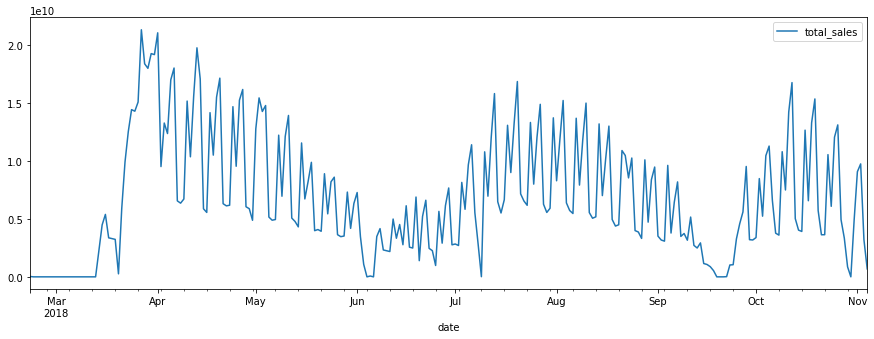

In [48]:
series = df_model.copy()
series.set_index('date', inplace=True)
df_total_sales = series[['total_sales']]
df_total_sales.plot(figsize=(15, 5))

In [49]:
df_model.to_csv(path_or_buf='data/clean_data_time_series.csv', index=False)
df_total_sales.head()

,total_sales
date,
2018-02-21,32030000
2018-02-22,0
2018-02-23,180000
2018-02-24,0
2018-02-25,0


## Uji Stationer Data

In [50]:
from statsmodels.tsa.stattools import adfuller
from jcopml.time_series import stationarity_tester
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller

def test_stationarity(data):
    # Menghitung statistik ADF
    result = adfuller(data)
    print('ADF Statistik:', result[0])
    print('P-value:', result[1])
    print('Banyaknya observasi:', result[3])
    print('Nilai kritis:')
    for key, value in result[4].items():
        print('\t', key, ':', value)

    # Melakukan pengecekan p-value
    if result[1] <= 0.05:
        print("Data bersifat stasioner.")
    else:
        print("Data tidak stasioner.")

# Memanggil fungsi untuk menguji kestasioneran data
test_stationarity(df_total_sales)

ADF Statistik: -3.149853408000777
P-value: 0.023077124441715453
Banyaknya observasi: 242
Nilai kritis:
	 1% : -3.457664132155201
	 5% : -2.8735585105960224
	 10% : -2.5731749894132916
Data bersifat stasioner.


In [51]:
stationarity_tester(df_total_sales)

ADF:        Series is stationary
KPSS:       Series is trend stationary
Conclusion: Series is stationary


,Test Statistic,p-value,Critical Value (1%),Critical Value (5%),Critical Value (10%),reject_null
ADF,-3.1499,0.0231,-3.4577,-2.8736,-2.5732,True
KPSS,0.1315,0.1000,0.7390,0.4630,0.3470,False


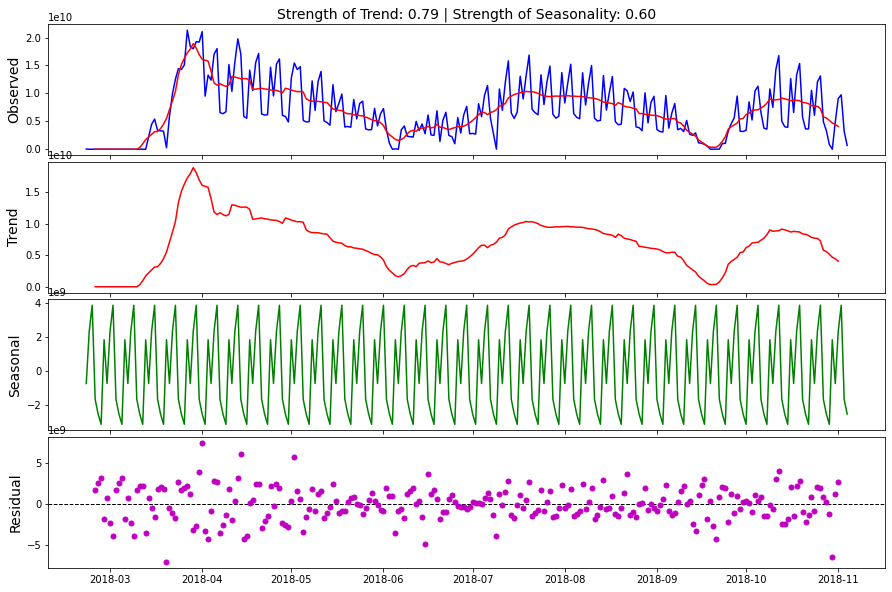

In [52]:
additive_decomposition(df_total_sales, plot=True)

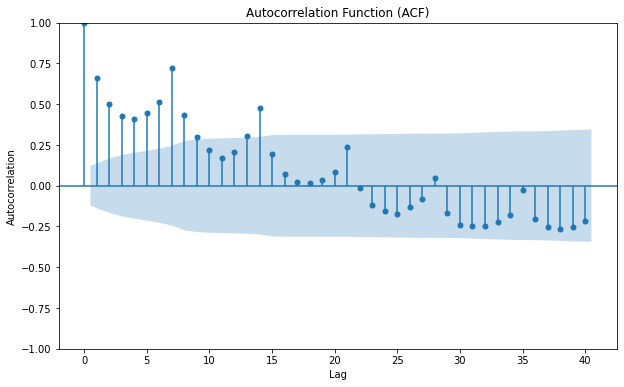

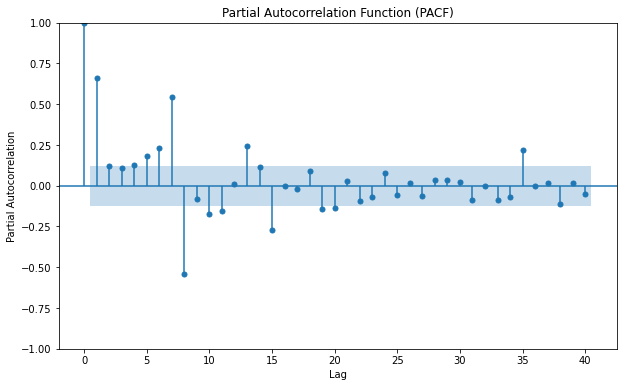

In [53]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF
fig, ax = plt.subplots(figsize=(10, 6))
plot_acf(df_total_sales, ax=ax, lags=40)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF)')
plt.show()

# Plot PACF
fig, ax = plt.subplots(figsize=(10, 6))
plot_pacf(df_total_sales, ax=ax, lags=40)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

# Forecasting with SARIMAX

In [54]:
data_train, data_test = df_total_sales[:-30], df_total_sales[-30:]

model_auto_sarimax = auto_arima(df_total_sales, start_P=1, start_Q=1, max_P=10, max_Q=10, m=12, start_D=1, max_D=10, random_state=42, 
                                max_order=None, seasonal=True, trace=False, error_action='ignore', suppress_warnings=True, stepwise=True,
                                information_criterion='aicc')

model_auto_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  257
Model:             SARIMAX(5, 0, 2)x(2, 0, 2, 12)   Log Likelihood               -5988.250
Date:                            Sun, 02 Jul 2023   AIC                          12002.501
Time:                                    23:25:24   BIC                          12048.639
Sample:                                02-21-2018   HQIC                         12021.055
                                     - 11-04-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.159e+09   5.88e-12   1.97e+20      0.000    1.16e+09    1.16e+09
ar.L1          0.3395      0.102      3.339      0.001       0.140       0.539
ar.L2          0.6835      0.109      6.260      0.000       0.470       0.897
ar.L3         -0.4200      0.114     -3.682      0.000      -0.644      -0.196
ar.L4         -0.2240      0.089     -2.505      0.012      -0.399      -0.049
ar.L5          0.5635      0.082      6.864      0.000       0.403       0.724
ma.L1          0.2620      0.122      2.146      0.032       0.023       0.501
ma.L2         -0.4149      0.120     -3.457      0.001      -0.650      -0.180
ar.S.L12      -1.7734      0.082    -21.718      0.000      -1.933      -1.613
ar.S.L24      -0.9234      0.084    -10.955      0.000      -1.089      -0.758
ma.S.L12       1.6106      0.181      8.922      0.000       1.257       1.964
ma.S.L24       0.7077      0.189      3.745      0.000       0.337       1.078
sigma2      1.321e+19   2.04e-20   6.48e+38      0.000    1.32e+19    1.32e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 2.88
Prob(Q):                              0.92   Prob(JB):                         0.24
Heteroskedasticity (H):               0.60   Skew:                             0.10
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.01e+54. Standard errors may be unstable.
"""

In [55]:
sarimax = SARIMAX(df_total_sales,order=(5, 0, 2),
                  seasonal_order=(2, 0, 2, 12),
                  enforce_stationarity=False,
                  enforce_invertibility=False)
model_sarimax = sarimax.fit()

pred = model_sarimax.predict()
actual = df_total_sales

mse_sarimax = mean_squared_error(actual, pred)
rmse_sarimax = np.sqrt(mse_sarimax)
mae_sarimax = mean_absolute_error(actual,pred)
r2_sarimax = r2_score(actual,pred)

print("MSE\t: ", mse_sarimax)
print("RMSE\t: ", rmse_sarimax)
print("MAE\t: ", mae_sarimax)
print("R2\t: ", r2_sarimax)

evaluasi(actual, pred, "Time Series", "SARIMAX")

MSE	:  1.0724177211557845e+19
RMSE	:  3274778956.1370163
MAE	:  2556669594.3912024
R2	:  0.5951120446741545


,Method,Algorithm,MSE,RMSE,MAE,R2
0,Time Series,SARIMAX,10724177211557844992.0000,3274778956.1370,2556669594.3912,0.5951


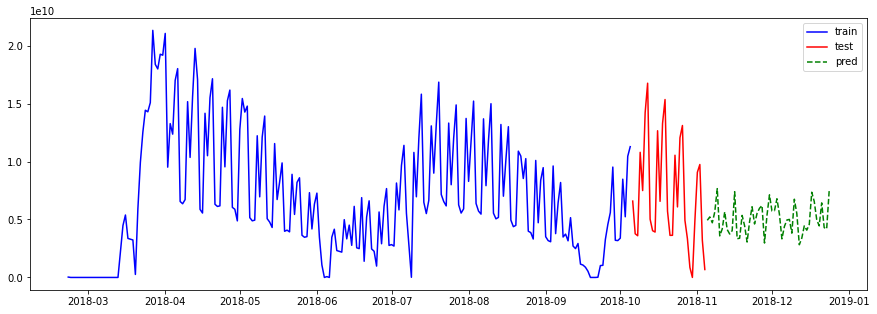

In [56]:
n_forecast = len(data_test) + 20
pred = model_auto_sarimax.predict(n_forecast)

plt.figure(figsize=(15,5))
plt.plot(data_train, "b-", label="train")
plt.plot(data_test, "r-", label="test")
plt.plot(pred, "g--", label="pred")
plt.legend()

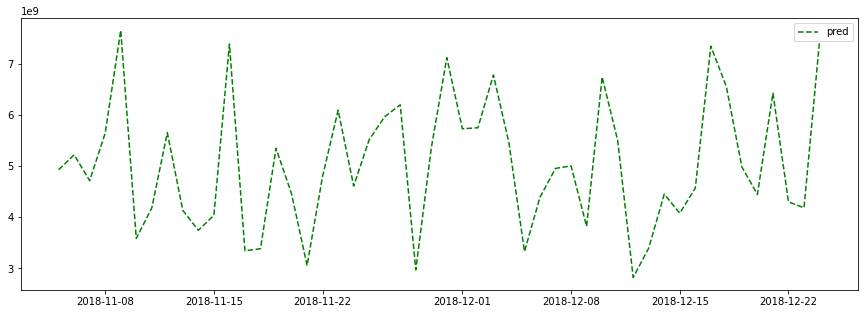

In [57]:
plt.figure(figsize=(15,5))
plt.plot(pred, "g--", label="pred")
plt.legend()

### Visualisasi

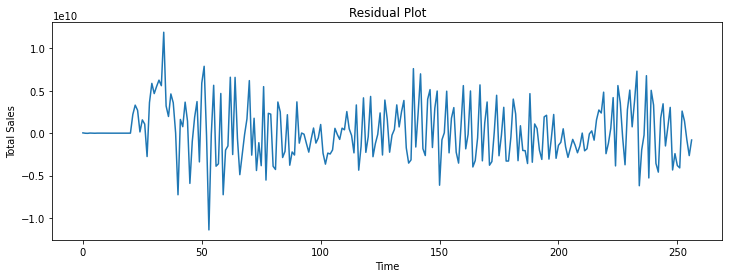

In [58]:
residuals = pd.DataFrame(model_sarimax.resid)
temp_df = residuals.reset_index()
temp_df['date']=pd.to_datetime(temp_df['date'],errors='coerce')
residuals = temp_df.set_index('date')

fig = plt.gcf()
fig.set_size_inches(12, 4)
plt.title('Residual Plot')
plt.xlabel('Time')
plt.ylabel("Total Sales")
plt.plot(residuals.values )

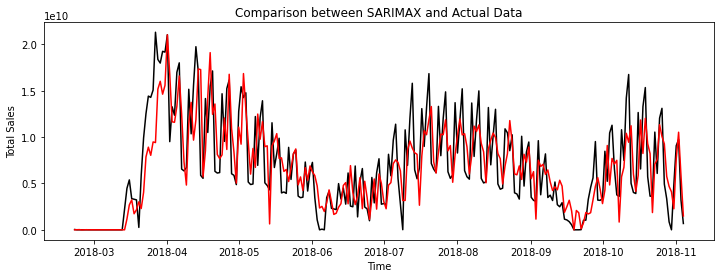

In [59]:
index_list = df_total_sales.index.tolist()
preds = model_sarimax.predict()
preds = preds.set_axis(index_list)
preds = preds.to_frame()

fig = plt.gcf()
fig.set_size_inches(12, 4)
plt.title(f'Comparison between SARIMAX and Actual Data')
plt.xlabel('Time')
plt.ylabel("Total Sales")

plt.plot(df_total_sales, label = 'Actual', color = 'black')
plt.plot(preds, label = 'Predicted', color = 'r')

In [60]:
data_forecast = get_forecast_values(df_total_sales, 30, model_sarimax) 
data_forecast

Tanggal Terakhir		: 2018-11-04 00:00:00
Tanggal Forecast Dimulai Dari	: 2018-11-05 00:00:00


,Forecast
2018-11-05,3081084577.8842
2018-11-06,2981294909.1331
2018-11-07,4233241196.5957
2018-11-08,6228181287.3068
2018-11-09,6342031988.3335
2018-11-10,5846046490.8895
2018-11-11,6969595824.3226
2018-11-12,5161447593.2766
2018-11-13,4026741107.1285
2018-11-14,3789366213.1723


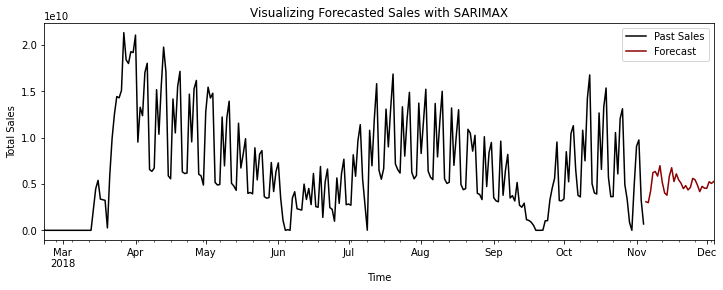

In [61]:
forecast_plot(df_total_sales, data_forecast, 'SARIMAX')

# Forecasting with ARIMA

In [62]:
data_train, data_test = df_total_sales[:-30], df_total_sales[-30:]

model_auto_arima = auto_arima(df_total_sales, start_p=1, start_q=1, max_p=10, max_q=10, start_d=1, max_d=10, random_state=42, max_order=None, 
                              seasonal=False, trace=False, error_action='ignore', suppress_warnings=True, stepwise=True, information_criterion='aicc')

model_auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  257
Model:              SARIMAX(10, 0, 0)   Log Likelihood               -5930.283
Date:                Sun, 02 Jul 2023   AIC                          11884.567
Time:                        23:25:46   BIC                          11927.156
Sample:                    02-21-2018   HQIC                         11901.694
                         - 11-04-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.009e+09   2.95e-12   3.42e+20      0.000    1.01e+09    1.01e+09
ar.L1          0.5688      0.051     11.242      0.000       0.470       0.668
ar.L2         -0.0026      0.080     -0.033      0.974      -0.159       0.153
ar.L3          0.1528      0.071      2.167      0.030       0.015       0.291
ar.L4         -0.0087      0.047     -0.186      0.853      -0.100       0.083
ar.L5          0.0466      0.048      0.980      0.327      -0.047       0.140
ar.L6         -0.0114      0.047     -0.241      0.810      -0.104       0.081
ar.L7          0.7268      0.050     14.622      0.000       0.629       0.824
ar.L8         -0.4352      0.059     -7.378      0.000      -0.551      -0.320
ar.L9         -0.0101      0.086     -0.117      0.907      -0.178       0.158
ar.L10        -0.1740      0.080     -2.174      0.030      -0.331      -0.017
sigma2       6.45e+18    3.5e-21   1.84e+39      0.000    6.45e+18    6.45e+18
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):               102.52
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               0.40   Skew:                             0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.02e+54. Standard errors may be unstable.
"""

In [63]:
arima = ARIMA(df_total_sales, order=(10, 0, 0))
model_arima = arima.fit()

pred = model_arima.predict()
actual = df_total_sales

mse_arima = mean_squared_error(actual, pred)
rmse_arima = np.sqrt(mse_arima)
mae_arima = mean_absolute_error(actual, pred)
r2_arima = r2_score(actual, pred)

print("MSE\t: ", mse_arima)
print("RMSE\t: ", rmse_arima)
print("MAE\t: ", mae_arima)
print("R2\t: ", r2_arima)

evaluasi(actual, pred, "Time Series", "ARIMA")

MSE	:  6.461089874353801e+18
RMSE	:  2541867399.050116
MAE	:  1746871715.7090163
R2	:  0.7560635732889367


,Method,Algorithm,MSE,RMSE,MAE,R2
0,Time Series,SARIMAX,10724177211557844992.0000,3274778956.1370,2556669594.3912,0.5951
1,Time Series,ARIMA,6461089874353801216.0000,2541867399.0501,1746871715.7090,0.7561


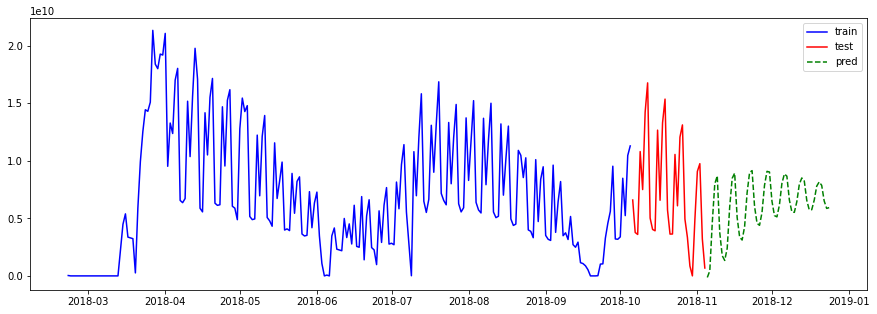

In [64]:
n_forecast = len(data_test) + 20
pred = model_auto_arima.predict(n_forecast)

plt.figure(figsize=(15,5))
plt.plot(data_train, "b-", label="train")
plt.plot(data_test, "r-", label="test")
plt.plot(pred, "g--", label="pred")
plt.legend()

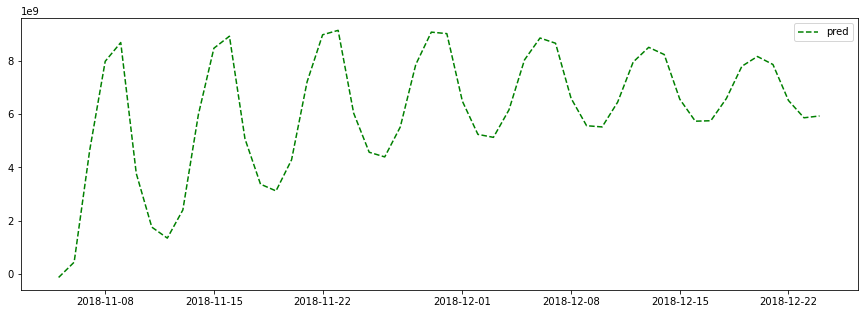

In [65]:
plt.figure(figsize=(15,5))
plt.plot(pred, "g--", label="pred")
plt.legend()

### Visualisasi

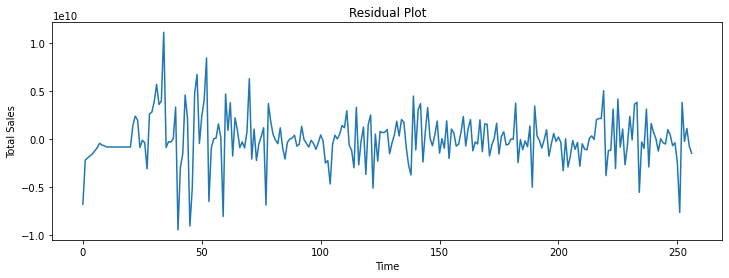

In [66]:
residuals = pd.DataFrame(model_arima.resid)
temp_df = residuals.reset_index()
temp_df['date']=pd.to_datetime(temp_df['date'],errors='coerce')
residuals = temp_df.set_index('date')

fig = plt.gcf()
fig.set_size_inches(12, 4)
plt.title('Residual Plot')
plt.xlabel('Time')
plt.ylabel("Total Sales")
plt.plot(residuals.values )

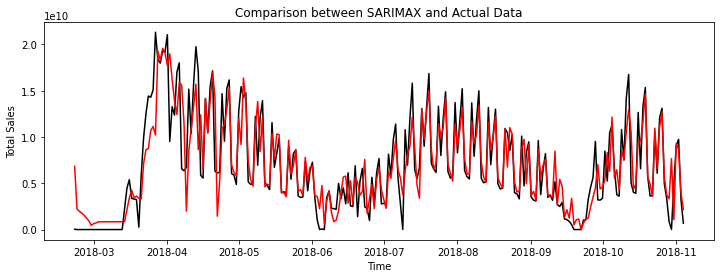

In [67]:
index_list = df_total_sales.index.tolist()
preds = model_arima.predict()
preds = preds.set_axis(index_list)
preds = preds.to_frame()

fig = plt.gcf()
fig.set_size_inches(12, 4)
plt.title(f'Comparison between SARIMAX and Actual Data')
plt.xlabel('Time')
plt.ylabel("Total Sales")

plt.plot(df_total_sales, label = 'Actual', color = 'black')
plt.plot(preds, label = 'Predicted', color = 'r')

In [68]:
data_forecast = get_forecast_values(df_total_sales, 30, model_arima)
data_forecast

Tanggal Terakhir		: 2018-11-04 00:00:00
Tanggal Forecast Dimulai Dari	: 2018-11-05 00:00:00


,Forecast
2018-11-05,-178080021.6846
2018-11-06,343815395.6370
2018-11-07,4511682075.9865
2018-11-08,7826787371.8497
2018-11-09,8507405581.5574
2018-11-10,3587134406.7786
2018-11-11,1567576318.0132
2018-11-12,1108076446.1638
2018-11-13,2098510831.6141
2018-11-14,5640748258.1337


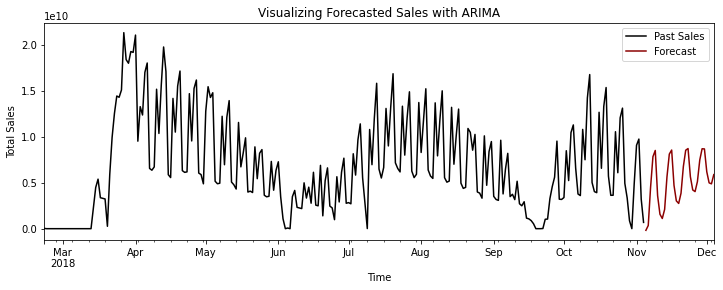

In [69]:
forecast_plot(df_total_sales, data_forecast, 'ARIMA')

# Forecast with Model Machine Learning

Shifting the data with 30 periods

In [70]:
df_model_ml = df_model[['date', 'total_sales', 'tickets_sold']].copy()
df_model_ml.to_csv(path_or_buf='data/clean_data_machine_learning.csv', index=False)

for lag in range(1, 31):
    df_model_ml[f'lag_{lag}'] = df_model_ml['total_sales'].shift(periods=lag)

df_model_ml.fillna(0, inplace=True)
df_model_ml['date'] = pd.to_datetime(df_model_ml['date'])
df_model_ml = df_model_ml.set_index('date')
df_model_ml.drop(columns=['tickets_sold'], inplace=True)

df_model_ml.head()


,total_sales,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,...,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30
date,,,,,,,,,,,,,,,,,,,,,
2018-02-21,32030000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2018-02-22,0,32030000.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2018-02-23,180000,0.0000,32030000.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2018-02-24,0,180000.0000,0.0000,32030000.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2018-02-25,0,0.0000,180000.0000,0.0000,32030000.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


### Splitting Data

In [71]:
def train_test_split(data, days):
    X_train = data.iloc[:-days , 1:]  # removing last 30 days and total_sales col
    y_train = data.iloc[:-days , :1] # removing last 30 days and only taking total_Sales col
    X_test = data.iloc[-days: , 1:]  # considering last 30 days without total sales
    y_test = data.iloc[-days: , :1]  # total sales of last 30 days
    
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = train_test_split(df_model_ml, 30)

## Random Forest

In [72]:
model_RF = RandomForestRegressor(n_jobs=-1, random_state=42, n_estimators=500)
model_RF.fit(X_train, y_train)

print('Training\t:', model_RF.score(X_train, y_train))
print('Testing\t\t:', model_RF.score(X_test, y_test))

Training	: 0.9704383368835615
Testing		: 0.6303889574312159


### Hasil Testing Random Forest 

In [73]:
y_test_pred = model_RF.predict(X_test)

mse_RF = mean_squared_error(y_test,y_test_pred)
rmse_RF = np.sqrt(mse_RF)
mae_RF = mean_absolute_error(y_test,y_test_pred)
r2_RF = r2_score(y_test,y_test_pred)

print("MSE\t: ", mse_RF)
print("RMSE\t: ", rmse_RF)
print("MAE\t: ", mae_RF)
print("R2\t: ", r2_RF)

evaluasi(y_test, y_test_pred, "Machine Learning", "Random Forest")

MSE	:  7.667319675547271e+18
RMSE	:  2768992538.0085936
MAE	:  1936012818.6473334
R2	:  0.6303889574312159


,Method,Algorithm,MSE,RMSE,MAE,R2
0,Time Series,SARIMAX,10724177211557844992.0000,3274778956.1370,2556669594.3912,0.5951
1,Time Series,ARIMA,6461089874353801216.0000,2541867399.0501,1746871715.7090,0.7561
2,Machine Learning,Random Forest,7667319675547271168.0000,2768992538.0086,1936012818.6473,0.6304


## XGBoost

In [74]:
model_XGB = XGBRegressor(n_jobs=-1, random_state=42, n_estimators=500, objective='reg:squarederror')
model_XGB.fit(X_train.values, y_train.values)

print('Training\t:', model_XGB.score(X_train, y_train))
print('Testing\t\t:', model_XGB.score(X_test, y_test))

Training	: 0.9999999999371403
Testing		: 0.3706445536304983


### Hasil Testing XGBoost

In [75]:
y_test_pred = model_XGB.predict(X_test)

mse_XGB = mean_squared_error(y_test,y_test_pred)
rmse_XGB = np.sqrt(mse_XGB)
mae_XGB = mean_absolute_error(y_test,y_test_pred)
r2_XGB = r2_score(y_test,y_test_pred)

print("MSE\t: ", mse_XGB)
print("RMSE\t: ", rmse_XGB)
print("MAE\t: ", mae_XGB)
print("R2\t: ", r2_XGB)

evaluasi(y_test, y_test_pred, "Machine Learning", "XGBoost")

MSE	:  1.305553363158435e+19
RMSE	:  3613244197.6130466
MAE	:  2447355578.9666667
R2	:  0.3706445536304983


,Method,Algorithm,MSE,RMSE,MAE,R2
0,Time Series,SARIMAX,10724177211557844992.0000,3274778956.1370,2556669594.3912,0.5951
1,Time Series,ARIMA,6461089874353801216.0000,2541867399.0501,1746871715.7090,0.7561
2,Machine Learning,Random Forest,7667319675547271168.0000,2768992538.0086,1936012818.6473,0.6304
3,Machine Learning,XGBoost,13055533631584350208.0000,3613244197.6130,2447355578.9667,0.3706


## Linear Regression

In [76]:
from sklearn.linear_model import LinearRegression

model_LR = LinearRegression()
model_LR.fit(X_train, y_train)

print('Training\t:', model_LR.score(X_train, y_train))
print('Testing\t\t:', model_LR.score(X_test, y_test))

Training	: 0.8286189254175083
Testing		: 0.6012740135867035


### Hasil Testing Linear Regression

In [77]:
y_test_pred = model_LR.predict(X_test)

mse_LR = mean_squared_error(y_test,y_test_pred)
rmse_LR = np.sqrt(mse_LR)
mae_LR = mean_absolute_error(y_test,y_test_pred)
r2_LR = r2_score(y_test,y_test_pred)

print("MSE\t: ", mse_LR)
print("RMSE\t: ", rmse_LR)
print("MAE\t: ", mae_LR)
print("R2\t: ", r2_LR)

result = evaluasi(y_test, y_test_pred, "Machine Learning", "Linear Regression")
result

MSE	:  8.271288594441086e+18
RMSE	:  2875984804.2785425
MAE	:  2074498447.4855525
R2	:  0.6012740135867035


,Method,Algorithm,MSE,RMSE,MAE,R2
0,Time Series,SARIMAX,10724177211557844992.0000,3274778956.1370,2556669594.3912,0.5951
1,Time Series,ARIMA,6461089874353801216.0000,2541867399.0501,1746871715.7090,0.7561
2,Machine Learning,Random Forest,7667319675547271168.0000,2768992538.0086,1936012818.6473,0.6304
3,Machine Learning,XGBoost,13055533631584350208.0000,3613244197.6130,2447355578.9667,0.3706
4,Machine Learning,Linear Regression,8271288594441085952.0000,2875984804.2785,2074498447.4856,0.6013


## Forecast Model Machine Learning

mengambil tanggal terakhir dari data

In [78]:
df_forecast = df_model_ml.copy()
print(df_forecast.index[-1])
print(df_forecast.index[-1] + pd.DateOffset(days=1))

2018-11-04 00:00:00
2018-11-05 00:00:00


melakukan flip sebanyak 30 data agar data yang di prediksi berada pada kolom total_sales

In [79]:
def get_forecast_date(data):
    forecast_date = data.index[-1] + pd.DateOffset(days=1)
    return forecast_date

def append_row(data):
    new_row = np.flip(np.append(data['total_sales'][-30:].values, np.nan)) 
    forecast_date = get_forecast_date(data)
    data.loc[forecast_date] = new_row
    return data, forecast_date

def model_forecast(model, data):
    new_row = np.flip(data['total_sales'][-30:].values) 
    ypred = model.predict([new_row.tolist()])

    data, forecast_date = append_row(data)
    data['total_sales'].loc[forecast_date] = ypred 
    return data

def model_forecast_n(n, model, data):
    for i in range(n):
        data = model_forecast(model, data)
    return data

In [80]:
df_forecast = df_model_ml.copy()
df_forecast.tail()

,total_sales,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,...,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30
date,,,,,,,,,,,,,,,,,,,,,
2018-10-31,4871998000,2070000.0000,859461000.0000,3341139000.0000,4930179998.0000,13109354998.0000,12051972986.0000,6085099998.0000,10545025000.0000,3636149998.0000,...,7495844991.0000,10796814997.0000,3599469998.0000,3768334999.0000,6588964978.0000,11283699990.0000,10453034991.0000,5234279991.0000,8477999999.0000,3387570000.0000
2018-11-01,9071854998,4871998000.0000,2070000.0000,859461000.0000,3341139000.0000,4930179998.0000,13109354998.0000,12051972986.0000,6085099998.0000,10545025000.0000,...,14213117993.0000,7495844991.0000,10796814997.0000,3599469998.0000,3768334999.0000,6588964978.0000,11283699990.0000,10453034991.0000,5234279991.0000,8477999999.0000
2018-11-02,9744695000,9071854998.0000,4871998000.0000,2070000.0000,859461000.0000,3341139000.0000,4930179998.0000,13109354998.0000,12051972986.0000,6085099998.0000,...,16759698993.0000,14213117993.0000,7495844991.0000,10796814997.0000,3599469998.0000,3768334999.0000,6588964978.0000,11283699990.0000,10453034991.0000,5234279991.0000
2018-11-03,3208490000,9744695000.0000,9071854998.0000,4871998000.0000,2070000.0000,859461000.0000,3341139000.0000,4930179998.0000,13109354998.0000,12051972986.0000,...,5023992987.0000,16759698993.0000,14213117993.0000,7495844991.0000,10796814997.0000,3599469998.0000,3768334999.0000,6588964978.0000,11283699990.0000,10453034991.0000
2018-11-04,682985000,3208490000.0000,9744695000.0000,9071854998.0000,4871998000.0000,2070000.0000,859461000.0000,3341139000.0000,4930179998.0000,13109354998.0000,...,4032354996.0000,5023992987.0000,16759698993.0000,14213117993.0000,7495844991.0000,10796814997.0000,3599469998.0000,3768334999.0000,6588964978.0000,11283699990.0000


### Random Forest

In [81]:
df_forecast = df_model_ml.copy()
forecast_date = get_forecast_date(df_forecast)
print(forecast_date)

data = model_forecast_n(30, model_RF, df_forecast)
data[['total_sales']][-30:]

2018-11-05 00:00:00


,total_sales
date,
2018-11-05,1923427518.0980
2018-11-06,3755640964.6920
2018-11-07,4269789491.4500
2018-11-08,7169282358.4340
2018-11-09,9022183888.6600
2018-11-10,3812938733.2840
2018-11-11,2949332869.0720
2018-11-12,2705606793.5460
2018-11-13,4034977523.5220


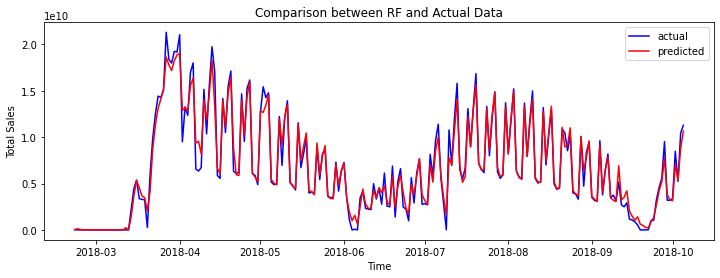

In [82]:
df_plot = df_model_ml.copy()
actual = df_plot['total_sales'][:-30]

index_list = actual.index.tolist()
prediction = pd.DataFrame({'prediction': (model_RF.predict(X_train))}, index=index_list)
prediction

fig = plt.gcf()
fig.set_size_inches(12, 4)
plt.title(f'Comparison between RF and Actual Data')
plt.xlabel('Time')
plt.ylabel("Total Sales")

plt.plot(actual, label = 'actual', color='b' )
plt.plot(prediction, label = 'predicted', color='r' )
plt.legend()

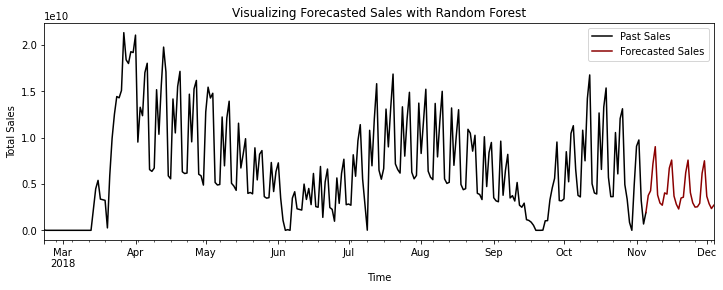

In [83]:
df_actual = df_forecast[['total_sales']].loc[:forecast_date]
forecast = df_forecast['total_sales'].loc[forecast_date:]

forecast_plot(df_actual, forecast, 'Random Forest')

### XGBoost Regressor

In [84]:
df_forecast = df_model_ml.copy()
forecast_date = get_forecast_date(df_forecast)
print(forecast_date)

data = model_forecast_n(30, model_XGB, df_forecast)
data[['total_sales']][-30:]

2018-11-05 00:00:00


,total_sales
date,
2018-11-05,847378240.0000
2018-11-06,993960832.0000
2018-11-07,1617412096.0000
2018-11-08,5644717568.0000
2018-11-09,5615609856.0000
2018-11-10,3026844160.0000
2018-11-11,2443409152.0000
2018-11-12,2556755200.0000
2018-11-13,4529493504.0000


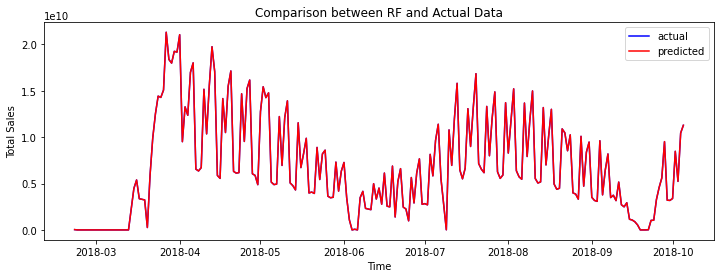

In [85]:
df_plot = df_model_ml.copy()
actual = df_plot['total_sales'][:-30]

index_list = actual.index.tolist()
prediction = pd.DataFrame({'prediction': (model_XGB.predict(X_train))}, index=index_list)
prediction

fig = plt.gcf()
fig.set_size_inches(12, 4)
plt.title(f'Comparison between RF and Actual Data')
plt.xlabel('Time')
plt.ylabel("Total Sales")

plt.plot(actual, label = 'actual', color='b' )
plt.plot(prediction, label = 'predicted', color='r' )
plt.legend()

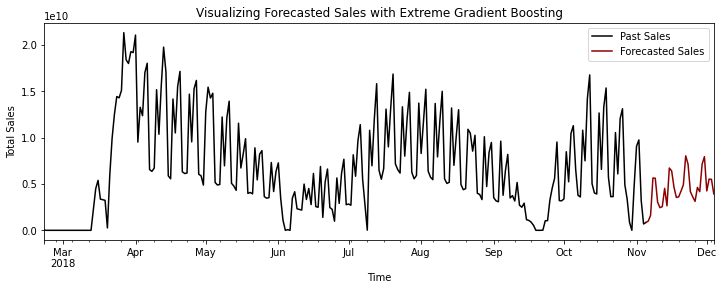

In [86]:
df_actual = df_forecast[['total_sales']].loc[:forecast_date]
forecast = df_forecast['total_sales'].loc[forecast_date:]

forecast_plot(df_actual, forecast, 'Extreme Gradient Boosting')

### Linear Regresssion

In [87]:
df_forecast = df_model_ml.copy()
forecast_date = get_forecast_date(df_forecast)
print(forecast_date)

data = model_forecast_n(30, model_LR, df_forecast)
data[['total_sales']][-30:]

2018-11-05 00:00:00


,total_sales
date,
2018-11-05,676441350.4253
2018-11-06,3174602549.1412
2018-11-07,3474320656.6611
2018-11-08,7581283035.5328
2018-11-09,10553335362.0501
2018-11-10,4613838783.7278
2018-11-11,1519695747.1758
2018-11-12,106090507.9915
2018-11-13,4154573699.7298


In [88]:
data_pred = model_LR.predict(X_train)
pred_LR = []
for n in range(len(data_pred)):
    for item in data_pred[n]:
        pred_LR.append(item)

print(pred_LR)

[814699367.4989548, 833460154.0105399, 817688253.9093429, 818088990.730445, 816648154.781393, 815309113.9800392, 813780238.108498, 830400804.5683303, 806700509.8918239, 814337277.6956105, 810045585.9657482, 807415887.5492696, 815980733.0198605, 821691187.8321551, 820201188.9288068, 806354268.7818167, 814341507.5878465, 813060066.2833437, 825168355.7108624, 812395193.1932616, 810935178.779425, 817976211.7794486, 2100454282.0777898, 3642200111.785056, 4617265050.431904, 3876083958.241883, 3925243016.911046, 3702542283.8357124, 2861457232.0555143, 6380046881.64543, 8848379845.2836, 9588802350.644075, 11273718481.569885, 11526314053.981434, 11459917016.653975, 20111387367.85103, 19563809398.146732, 19417557066.987873, 19566462175.78628, 18048318435.580868, 18268919253.965763, 14707860365.275492, 14602233879.424957, 13546502323.372925, 15394150478.652422, 13119822463.778988, 10803670267.953403, 6067378313.125219, 8899229589.779755, 10742876286.505245, 12621518317.040632, 17516302643.817085,

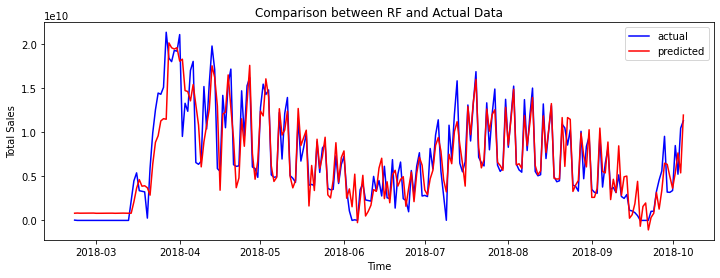

In [89]:
df_plot = df_model_ml.copy()
actual = df_plot['total_sales'][:-30]

index_list = actual.index.tolist()
prediction = pd.DataFrame({'prediction': (pred_LR)}, index=index_list)
prediction

fig = plt.gcf()
fig.set_size_inches(12, 4)
plt.title(f'Comparison between RF and Actual Data')
plt.xlabel('Time')
plt.ylabel("Total Sales")

plt.plot(actual, label = 'actual', color='b' )
plt.plot(prediction, label = 'predicted', color='r' )
plt.legend()

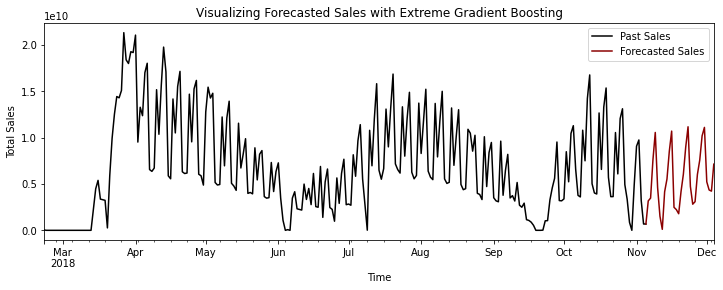

In [90]:
df_actual = df_forecast[['total_sales']].loc[:forecast_date]
forecast = df_forecast['total_sales'].loc[forecast_date:]

forecast_plot(df_actual, forecast, 'Extreme Gradient Boosting')

# Kesimpulan

In [91]:
result

,Method,Algorithm,MSE,RMSE,MAE,R2
0,Time Series,SARIMAX,10724177211557844992.0000,3274778956.1370,2556669594.3912,0.5951
1,Time Series,ARIMA,6461089874353801216.0000,2541867399.0501,1746871715.7090,0.7561
2,Machine Learning,Random Forest,7667319675547271168.0000,2768992538.0086,1936012818.6473,0.6304
3,Machine Learning,XGBoost,13055533631584350208.0000,3613244197.6130,2447355578.9667,0.3706
4,Machine Learning,Linear Regression,8271288594441085952.0000,2875984804.2785,2074498447.4856,0.6013


Berdasarkan hasil evaluasi diatas didapatkan bahwa algoritma ARIMA memiliki nilai R2 tertinggi yaitu 75,61%